In [1]:
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-19 19:10:45.723927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 19:10:45.850047: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 19:10:48.082431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-19 19:10:48.082602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

In [2]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

## Load data

In [3]:
ETTh1_data = pd.read_csv('data/ETTh1.csv', header=None).to_numpy()

In [4]:
ETTh1_data.shape

(17420, 7)

In [5]:
batch_size = 32
n_train = 8545
n_eval = 2881
n_test = 2881
train_loader, eval_loader, test_loader = get_loaders(ETTh1_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

In [6]:
cpt = 0
for x,y in train_loader : 
    cpt += x.shape[0]
print(cpt)

8449


## Train

In [7]:
import torch
import torch.nn as nn

class Embedding_inverted(nn.Module):
    def __init__(self, T, D):
        super(Embedding_inverted, self).__init__()
        self.emb = nn.Linear(T, D)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = x.permute(0,2,1)
        x_emb = self.emb(x)
        return self.dropout(x_emb)

class FeedForward(nn.Module):
    def __init__(self, D):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Conv1d(in_channels=D, out_channels=D*4, kernel_size=1),
          nn.GELU(),
          nn.Dropout(0.1),
          nn.Conv1d(in_channels=D*4, out_channels=D, kernel_size=1)
        )
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        #print("avant : ", x.shape)
        x = x.permute(0,2,1)
        x = self.feed_forward(x)
        #print("pendant : ", x.shape)
        x = x.permute(0,2,1)
        #print("apres : ", x.shape)
        x = self.drop(x)
        return x

    
class Attention(nn.Module):
    def __init__(self, D, proj_dim, nb_head=8):
        super(Attention, self).__init__()
        self.query_projection = nn.Linear(D, proj_dim)
        self.key_projection = nn.Linear(D, proj_dim)
        self.value_projection = nn.Linear(D, proj_dim)
        self.out_projection = nn.Linear(proj_dim, D)
        self.H = nb_head
        self.dropout = nn.Dropout(0.1)

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.H

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = 1. / torch.sqrt(torch.tensor(E))

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        out = V.reshape(B,L,-1)

        return self.out_projection(out)
        

class TrmBlock(nn.Module):
    def __init__(self, N, D, proj_dim):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= Attention(D, proj_dim)
      #self.multivariate_attention = nn.MultiheadAttention(D, num_heads=8)
      self.layer_norm1 = nn.LayerNorm(D)
      self.feed_forward = FeedForward(D)
      self.layer_norm2 = nn.LayerNorm(D)
      self.dropout = nn.Dropout(0.1)

    def forward(self, x):
      att = self.multivariate_attention(x,x,x)
      x = self.layer_norm1(x + self.dropout(att))
      #print("x_norm  : ", x.shape)
      #print("permute : ", xT.shape)
      x_forward = self.feed_forward(x)
      x= self.layer_norm2(x + x_forward)
      return x


class iTransformer(nn.Module):
    def __init__(self, N, T, D, S, proj_dim, num_blocks, use_norm=True):
      super(iTransformer, self).__init__()

      self.embedding = Embedding_inverted(T, D)
      self.trmblock = nn.ModuleList([TrmBlock(N, D, proj_dim) for _ in range(num_blocks)])
      self.projection = nn.Sequential(nn.Linear(D, D*4, bias=True), 
                                      nn.GELU(), 
                                      nn.Dropout(0.1),
                                      nn.Linear(D*4, S),
                                      nn.Dropout(0.1),
                                      )
      self.use_norm = use_norm
      self.S = S
      self.norm = nn.LayerNorm(D)
        
    def forward(self, x):
      #print("x : ",x.shape)
      if self.use_norm :
          means = x.mean(1, keepdim=True).detach()
          x = x - means
          std = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
          x/=std
            
      x = self.embedding(x)
      #print('emb : ',x.shape)
      for block in self.trmblock:
            x = block(x)
            
      x = self.norm(x)
      #print('trmblock : ',x.shape)
      y = self.projection(x)
      #print('proj : ', y.shape)
      y=y.permute(0,2,1)
      #print('final : ', y.shape)
      
      if self.use_norm : 
            y = y * (std[:,0,:].unsqueeze(1).repeat(1, self.S, 1))
            y = y + (means[:,0,:].unsqueeze(1).repeat(1, self.S, 1))
      return y[:, -self.S:, :]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cuda


In [9]:
N = 7 #nb variables
T = 96 #input length (lookback window)
D = 512 # 256 ou 512
S = 96 # 96 ou 192, 336, 720
hidden_dim = 64
num_blocks = 1 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, hidden_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-4, weight_decay=1e-5) # lr 10−3, 5 × 10−4, 10−4 


In [10]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device)

---- epoch :  0
loss train : 0.3877555041942956
loss eval : 0.6921403643421151
---- epoch :  1
loss train : 0.362716565829403
loss eval : 0.6704397150738672
---- epoch :  2
loss train : 0.3549044838491476
loss eval : 0.6783750182525679
---- epoch :  3
loss train : 0.34517417617563934
loss eval : 0.6795374381948601
---- epoch :  4
loss train : 0.3397553343817873
loss eval : 0.6756811331618916
Early stopping after 4 epochs without improvement.


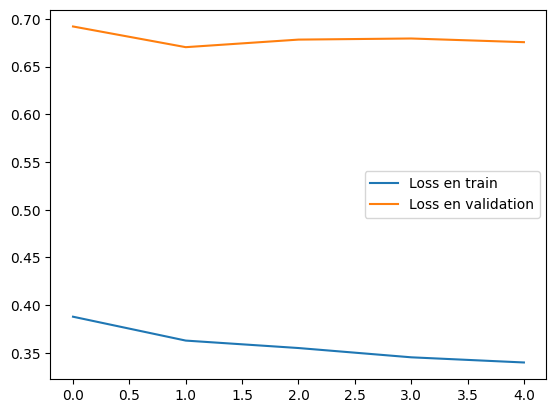

In [11]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

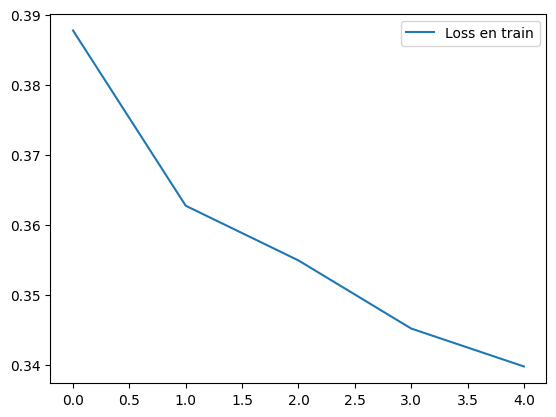

In [12]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.legend()
plt.show()

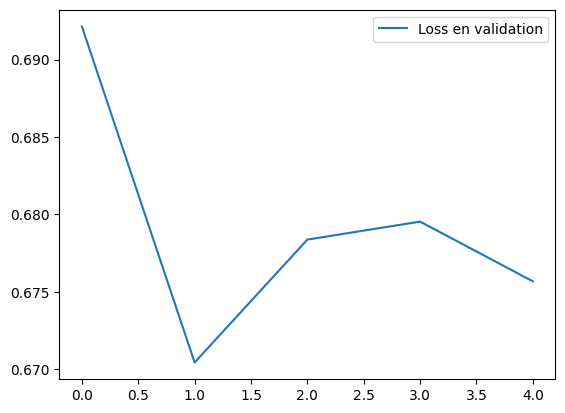

In [13]:
plt.figure()
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [14]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.38320202634415845
MAE :  0.4030214856294068


Affichage pour une modalité sur toute la durée de la prédiction

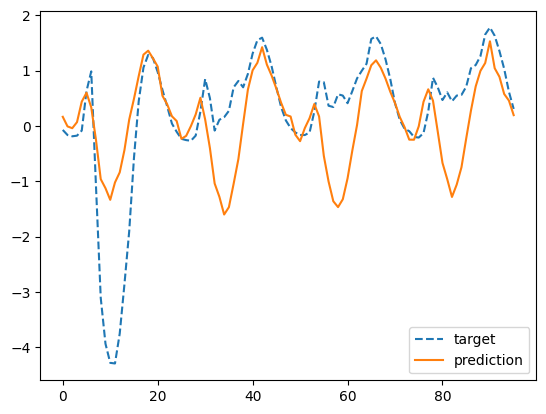

In [15]:
i = 0
plt.figure()
plt.plot(target[0,:,i].to("cpu"), "--", label="target")
plt.plot(yhat[0,:,i].to("cpu"),label="prediction")
plt.legend()
plt.show()

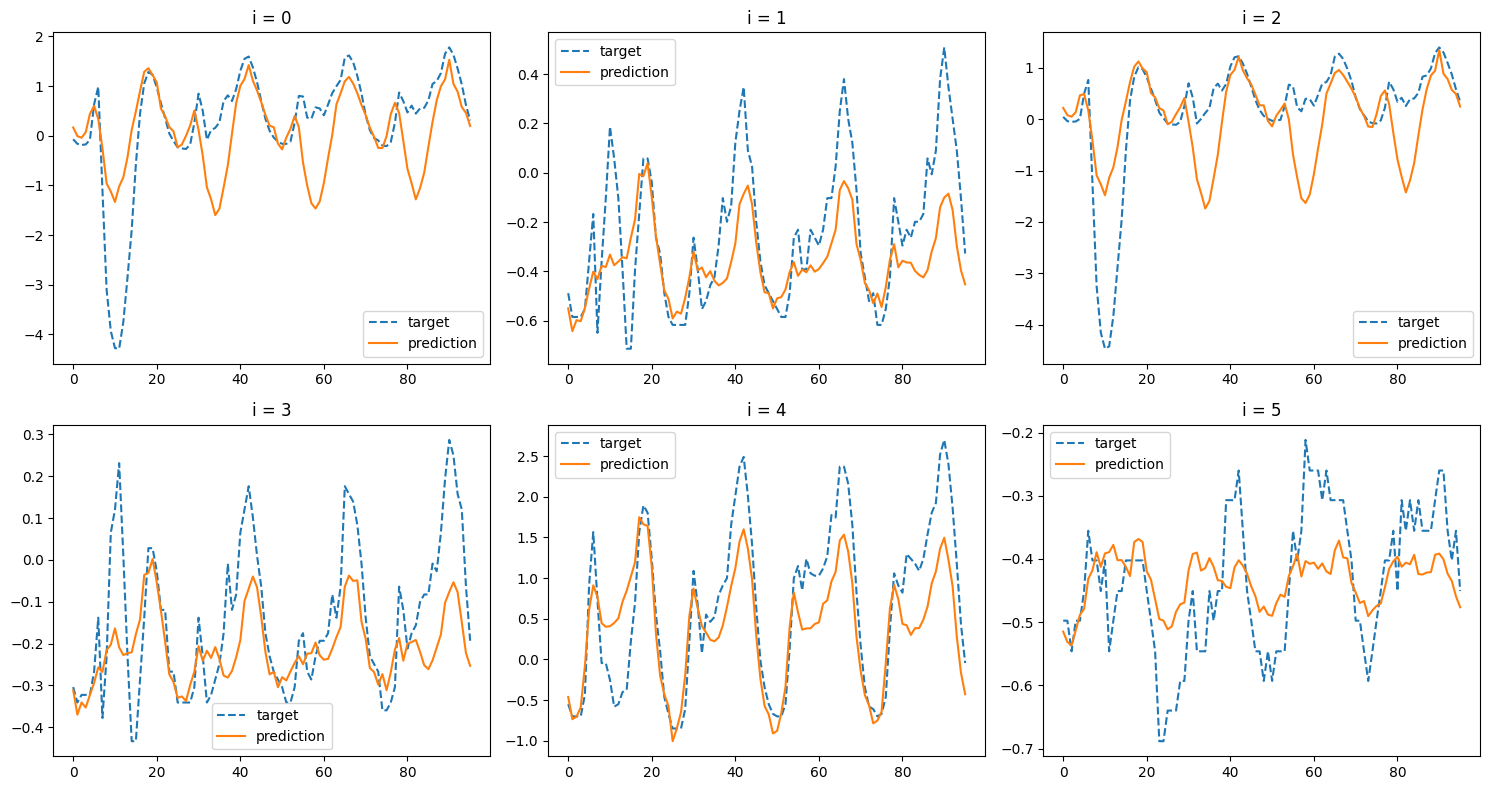

In [16]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(target[0, :, current_i].to("cpu"), "--", label="target")
    plt.plot(yhat[0, :, current_i].to("cpu"), label="prediction")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

Affichage de toutes les modalités à un instant t

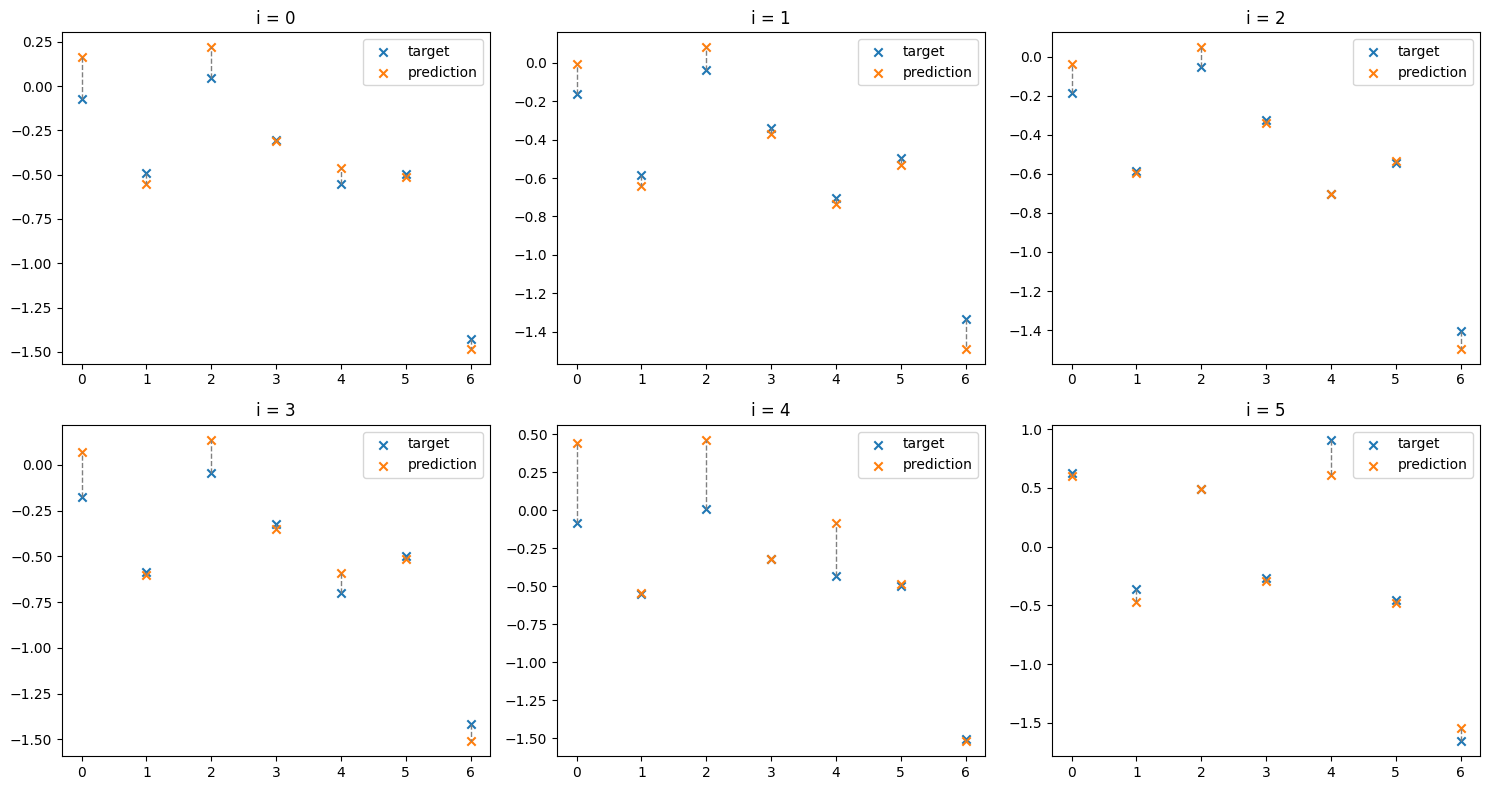

In [17]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i - 1
    
    plt.scatter(np.arange(len(target[0, current_i, :])), target[0, current_i, :].to("cpu"), marker='x', label="target")
    plt.scatter(np.arange(len(target[0, current_i, :])), yhat[0, current_i, :].to("cpu"), marker='x', label="prediction")

    for j in range(len(target[0, 0, :])):
        plt.plot([j, j], [target[0, current_i, j].to("cpu"), yhat[0, current_i, j].to("cpu")], color='gray', linestyle='--', linewidth=1)

    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()